In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
from mnist import MNIST
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255).astype(np.float32)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255).astype(np.float32)
print("Done.")

Loading dataset....
Done.


In [3]:
X_train=X_train*2 - 1
X_test=X_test*2 - 1
X_train=np.concatenate([X_train,X_test])

In [4]:
import sys
sys.path.append("../dnn_from_scratch")

In [5]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 703
Seed: 286


In [6]:
def generator():
    model=Sequential()
    model.add(dense(128,input_shape=(100),activation=functions.leakyRelu))
    model.add(dropout(0.3))
    model.add(dense(256,activation=functions.leakyRelu))
    model.add(dropout(0.3))
    model.add(dense(784,activation=functions.tanh))
    return model
g=generator()

In [7]:
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 128)                leakyRelu        12928
__________________________________________________________________________________________
2 dropout(dropout)        (None, 128)                echo             0
__________________________________________________________________________________________
3 dense(dense)            (None, 256)                leakyRelu        33024
__________________________________________________________________________________________
4 dropout(dropout)        (None, 256)                echo             0
__________________________________________________________________________________________
5 dense(

In [8]:
def discriminator():
    model=Sequential()
    model.add(dense(256,input_shape=(784),activation=functions.leakyRelu))
    model.add(dropout(0.3))
    model.add(dense(128,activation=functions.leakyRelu))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()

In [9]:
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 784)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 256)                leakyRelu        200960
__________________________________________________________________________________________
2 dropout(dropout)        (None, 256)                echo             0
__________________________________________________________________________________________
3 dense(dense)            (None, 128)                leakyRelu        32896
__________________________________________________________________________________________
4 dense(dense)            (None, 1)                  sigmoid          129
Total Params: 233,985
Trainable Params: 233,985
Non-trainable Params: 0


In [10]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [11]:
def run():
    batch_size=64
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
#         X = np.concatenate([real_images,generated_images])
        # Train discriminator
        y_real=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
        y_fake=np.random.uniform(0,0.1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        print("\rProgress: {:.2f} %     Dloss: {}    err: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,abs(err).mean(),time()-stt),end='')

EPOCH: 1 / 10
Progress: 99.84 %     Dloss: 17.563243865966797    err: 0.023176757618784904     Sample time: 0.019s    __
Epoch time: 0:24s


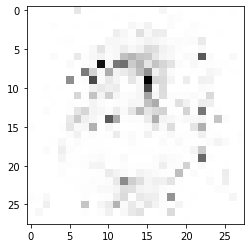

[0.900057]
EPOCH: 2 / 10
Progress: 99.84 %     Dloss: 23.00200080871582    err: 0.011905164457857609     Sample time: 0.020s    __
Epoch time: 0:22s


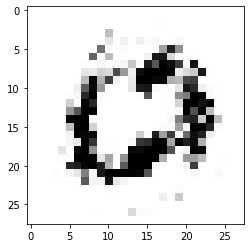

[0.21424213]
EPOCH: 3 / 10
Progress: 11.98 %     Dloss: 24.816051483154297    err: 0.014071285724639893     Sample time: 0.019s    _

In [ ]:
epochs=10
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    noise=np.random.normal(-1,1,(1,100)).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow(gen.reshape(28,28), cmap='Greys')
    plt.show()
    print(d.predict(gen)[0])

In [ ]:
noise=np.random.normal(-1,1,(1,100)).astype(np.float32)
gen=g.predict(noise)
plt.imshow(gen.reshape(28,28), cmap='Greys')
plt.show()
print(d.predict(gen))
img=X_train[np.random.randint(low=0,high=X_train.shape[0],size=1)]
plt.imshow(img.reshape(28,28), cmap='Greys')
plt.show()
print(d.predict(img))

In [ ]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
noise=np.random.randn(25,100).astype(np.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.imshow(gen[i].reshape(28,28), cmap='Greys')